In [ ]:
!pip install pydicom opencv-python tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

In [ ]:
!gdown 10UzcW33QlV0urc-NcLQMVUJhaUFg89JC  # sacado de la publicacion de phisyonet:   VinDr-SpineXR: A large annotated medical image dataset for spinal lesions detection and classification from radiographs

!unzip -o image_dicom.zip -d /content/image_dicom



Downloading...
From (original): https://drive.google.com/uc?id=10UzcW33QlV0urc-NcLQMVUJhaUFg89JC
From (redirected): https://drive.google.com/uc?id=10UzcW33QlV0urc-NcLQMVUJhaUFg89JC&confirm=t&uuid=88087286-334d-4181-b355-0eb62b24a376
To: /content/image_dicom.zip
100% 175M/175M [00:04<00:00, 39.5MB/s]
Archive:  image_dicom.zip
  inflating: /content/image_dicom/image_dicom/00eb023a60860beaab68f69907e0dc69.dicom  
  inflating: /content/image_dicom/image_dicom/01251acf915110beed9610368166337f.dicom  
  inflating: /content/image_dicom/image_dicom/010ed3d7677dbd1666cf86b9b063ba5c.dicom  
  inflating: /content/image_dicom/image_dicom/0185dde5a08c2c4abf43752bd9f11d78.dicom  
  inflating: /content/image_dicom/image_dicom/00ee38acbe4ce33e29d7050dbd5be38b.dicom  
  inflating: /content/image_dicom/image_dicom/014101c7f1d8e9991ad43e126eb9d184.dicom  
  inflating: /content/image_dicom/image_dicom/00bdfd977c95db42e507897177dc4696.dicom  
  inflating: /content/image_dicom/image_dicom/00d381730c131b6cf2

In [ ]:
import os
import numpy as np
import pydicom

# Verificar los archivos en el directorio
folder_path = '/content/image_dicom'
print("Archivos en el directorio:")
print(os.listdir(folder_path))

# Verificar manualmente la lectura de un archivo DICOM
try:
    test_file = os.path.join(folder_path, os.listdir(folder_path)[0])
    test_dicom = pydicom.dcmread(test_file)
    print("Archivo DICOM cargado correctamente: ", test_file)
    print("Dimensiones de la imagen DICOM: ", test_dicom.pixel_array.shape)
except Exception as e:
    print(f"Error al leer el archivo DICOM de prueba: {e}")


Archivos en el directorio:
['image_dicom']
Error al leer el archivo DICOM de prueba: [Errno 21] Is a directory: '/content/image_dicom/image_dicom'


In [ ]:
import os

folder_path = '/content/image_dicom'
dicom_files = []

for root, _, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.dicom'):
            file_path = os.path.join(root, file)
            dicom_files.append(file_path)

print(f"Total archivos DICOM encontrados: {len(dicom_files)}")
print("Lista de archivos DICOM:")
for file_path in dicom_files:
    print(file_path)

Total archivos DICOM encontrados: 55
Lista de archivos DICOM:
/content/image_dicom/image_dicom/008a94da378ce757d9deed22f5fd3ae0.dicom
/content/image_dicom/image_dicom/00cd860d4cf84258a6b2f1da1e671a29.dicom
/content/image_dicom/image_dicom/003b54fbeba8d6135d64df1f2183ea6d.dicom
/content/image_dicom/image_dicom/004bb19be2c5c982e6ce64c9491b6d94.dicom
/content/image_dicom/image_dicom/00871801219b6904f1a2ef5e705a8282.dicom
/content/image_dicom/image_dicom/00bdfd977c95db42e507897177dc4696.dicom
/content/image_dicom/image_dicom/017ac0a596380fd108dbcc0e534554cb.dicom
/content/image_dicom/image_dicom/018c517be75aca8b944ac0aa67f774ec.dicom
/content/image_dicom/image_dicom/00073745e02e69432c002b527c565151.dicom
/content/image_dicom/image_dicom/00808691d1d170128ce93ea101fd91ea.dicom
/content/image_dicom/image_dicom/00fcfd1e6410590c9a6b2b498458fad7.dicom
/content/image_dicom/image_dicom/0095cd74d347ef4e05372aa1df37ae2b.dicom
/content/image_dicom/image_dicom/0188e0b48dc2f5ad807bd27900544527.dicom
/c

In [ ]:
import hashlib

def file_hash(filepath):
    """Calculate the MD5 hash of a file."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def remove_duplicates(folder_path):
    """Remove duplicate files in the specified folder."""
    seen_hashes = set()
    duplicate_files = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.dicom'):
                file_path = os.path.join(root, file)
                file_md5 = file_hash(file_path)
                if file_md5 in seen_hashes:
                    duplicate_files.append(file_path)
                else:
                    seen_hashes.add(file_md5)

    for file_path in duplicate_files:
        os.remove(file_path)
        print(f"Removed duplicate file: {file_path}")

remove_duplicates(folder_path)
len(folder_path)

20

In [ ]:
import os
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

def load_dicom_images(folder_path, img_size=(256, 256)):
    images = []
    labels = []  # Aquí asumimos que tienes etiquetas asociadas a tus imágenes DICOM
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.dicom'):
                file_path = os.path.join(root, file)
                print(f"Intentando cargar archivo DICOM: {file_path}")  # Agregando mensaje de depuración
                try:
                    dicom_data = pydicom.dcmread(file_path)
                    image = dicom_data.pixel_array
                    if image is not None:
                        # Redimensionar la imagen a img_size
                        image = cv2.resize(image, img_size)
                        images.append(image)
                        labels.append(0)  # Aquí 0 es un placeholder, reemplázalo con la etiqueta real
                    else:
                        print(f"Advertencia: La imagen DICOM en {file_path} está vacía.")
                except Exception as e:
                    print(f"Error al leer el archivo {file_path}: {e}")
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
folder_path = '/content/image_dicom'
images, labels = load_dicom_images(folder_path)

# Verificar si se cargaron las imágenes correctamente
if images.size == 0:
    raise ValueError("No se cargaron imágenes. Verifica que el directorio contiene archivos DICOM válidos.")

# Mostrar información sobre las imágenes cargadas
print(f"Se cargaron {len(images)} imágenes DICOM.")
print(f"Dimensiones de las imágenes: {images[0].shape} (ejemplo de la primera imagen)")


Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/008a94da378ce757d9deed22f5fd3ae0.dicom


/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00cd860d4cf84258a6b2f1da1e671a29.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/003b54fbeba8d6135d64df1f2183ea6d.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/004bb19be2c5c982e6ce64c9491b6d94.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00871801219b6904f1a2ef5e705a8282.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00bdfd977c95db42e507897177dc4696.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/017ac0a596380fd108dbcc0e534554cb.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/018c517be75aca8b944ac0aa67f774ec.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00073745e02e69432c002b527c565151.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00808691d1d170128ce93ea101fd91ea.dicom
Intentando cargar archivo DICOM: /content/image_dicom/i

In [ ]:
!gdown 1rQNUBYADy5REuFirVQb6AE9rT_hnkPlK #Csv que contiene el tipo de lesiones de las imagenes.


Downloading...
From: https://drive.google.com/uc?id=1rQNUBYADy5REuFirVQb6AE9rT_hnkPlK
To: /content/train.csv
100% 3.20M/3.20M [00:00<00:00, 27.8MB/s]


In [ ]:
import pandas as pd
import numpy as np
train_csv=pd.read_csv('train.csv', delimiter=';')
train_csv

,study_id,series_id,image_id,rad_id,lesion_type,xmin,ymin,xmax,ymax,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,712.636842,961.361404,786.587719,1011.782456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,789.949123,1452.126316,880.707018,1505.908772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,692.468421,655.473684,746.250877,709.256140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,820.201754,1603.389474,910.959649,1670.617544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00073745e02e69432c002b527c565151
4,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,739.528070,1203.382456,820.201754,1240.357895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19545,15354677a17156fbb5a617d694f2d25d,1ace0c1895cd8314a54de49ce33777fe,ac8e211d4421d61cbdbcb09cdf56689b,rad3,Osteophytes,787.542725,952.548110,868.524176,1027.394602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19546,15354677a17156fbb5a617d694f2d25d,1ace0c1895cd8314a54de49ce33777fe,ac8e211d4421d61cbdbcb09cdf56689b,rad3,Osteophytes,771.591833,864.204709,826.806459,930.462259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19547,d7f725fa068661e40db47afaf6811935,ab1126ea55e8423c17b39f1505930c8a,944a3478b664b658389013f512212562,rad1,No finding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19548,d7f725fa068661e40db47afaf6811935,4044143ef993d5738d742cb93a418c2c,e3b297bc7d0281331a674d107fb5d0eb,rad1,Osteophytes,1058.837967,1094.127085,1180.648928,1186.162033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#image_ids = train_csv['image_id']
#labels = train_csv['lesion_type']

In [ ]:
#labels = pd.factorize(labels)[0]
#labels

In [ ]:
def load_csv_labels(df):
    df = df[['image_id', 'lesion_type']]
    return dict(zip(df['image_id'], df['lesion_type']))

# Función para cargar imágenes DICOM y asociar etiquetas
def load_dicom_images(folder_path, labels_dict, img_size=(256, 256)):
    images = []
    labels = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.dicom'):
                file_path = os.path.join(root, file)
                image_id = os.path.splitext(file)[0]
                print(f"Intentando cargar archivo DICOM: {file_path}")  # Agregando mensaje de depuración
                try:
                    dicom_data = pydicom.dcmread(file_path)
                    image = dicom_data.pixel_array
                    if image is not None:
                        # Redimensionar la imagen a img_size
                        image = cv2.resize(image, img_size)
                        images.append(image)
                        if image_id in labels_dict:
                            labels.append(labels_dict[image_id])
                        else:
                            labels.append('No finding')  # Asumiendo 'No finding' como etiqueta por defecto
                    else:
                        print(f"Advertencia: La imagen DICOM en {file_path} está vacía.")
                except Exception as e:
                    print(f"Error al leer el archivo {file_path}: {e}")
    return np.array(images), np.array(labels)

# Ruta del directorio de imágenes
folder_path = '/content/image_dicom'  # Cambia esta ruta al directorio correcto donde están tus imágenes DICOM

# Cargar etiquetas desde el archivo CSV
labels_dict = load_csv_labels(train_csv)

# Cargar imágenes y etiquetas
images, labels = load_dicom_images(folder_path, labels_dict)

# Convertir las etiquetas a valores numéricos
labels = pd.factorize(labels)[0]

# Verificar si se cargaron las imágenes correctamente
if images.size == 0:
    raise ValueError("No se cargaron imágenes. Verifica que el directorio contiene archivos DICOM válidos.")

# Mostrar información sobre las imágenes cargadas
print(f"Se cargaron {len(images)} imágenes DICOM.")
print(f"Dimensiones de las imágenes: {images[0].shape} (ejemplo de la primera imagen)")

Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/008a94da378ce757d9deed22f5fd3ae0.dicom


/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00cd860d4cf84258a6b2f1da1e671a29.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/003b54fbeba8d6135d64df1f2183ea6d.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/004bb19be2c5c982e6ce64c9491b6d94.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00871801219b6904f1a2ef5e705a8282.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00bdfd977c95db42e507897177dc4696.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/017ac0a596380fd108dbcc0e534554cb.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/018c517be75aca8b944ac0aa67f774ec.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00073745e02e69432c002b527c565151.dicom
Intentando cargar archivo DICOM: /content/image_dicom/image_dicom/00808691d1d170128ce93ea101fd91ea.dicom
Intentando cargar archivo DICOM: /content/image_dicom/i

In [ ]:
# Preprocesar las imágenes (normalización)
images = images / np.max(images)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Asegurarse de que las imágenes tienen el canal de color necesario (si aplica)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Imprimir la forma de X_train para verificar las dimensiones
print(f"Forma de X_train: {X_train.shape}")

input_shape = X_train.shape[1:]  # Esto tomará todas las dimensiones excepto el tamaño del lote
print(f"Forma de entrada del modelo: {input_shape}")

Forma de X_train: (44, 256, 256, 1)
Forma de entrada del modelo: (256, 256, 1)


Epoch 1/20
2/2 [==============================] - 7s 1s/step - loss: 1.7517 - accuracy: 0.3636 - val_loss: 0.6839 - val_accuracy: 0.5455
Epoch 2/20
2/2 [==============================] - 1s 603ms/step - loss: 0.7099 - accuracy: 0.3864 - val_loss: 5.2018 - val_accuracy: 0.2727
Epoch 3/20
2/2 [==============================] - 1s 568ms/step - loss: 1.8460 - accuracy: 0.3864 - val_loss: 1.1788 - val_accuracy: 0.2727
Epoch 4/20
2/2 [==============================] - 1s 606ms/step - loss: 0.6511 - accuracy: 0.4318 - val_loss: 1.6017 - val_accuracy: 0.5455
Epoch 5/20
2/2 [==============================] - 1s 574ms/step - loss: 2.3711 - accuracy: 0.4773 - val_loss: 0.7007 - val_accuracy: 0.5455
Epoch 6/20
2/2 [==============================] - 1s 579ms/step - loss: 0.6225 - accuracy: 0.4545 - val_loss: 6.3066 - val_accuracy: 0.2727
Epoch 7/20
2/2 [==============================] - 1s 559ms/step - loss: 2.2036 - accuracy: 0.3864 - val_loss: 5.7937 - val_accuracy: 0.2727
Epoch 8/20
2/2 [=======

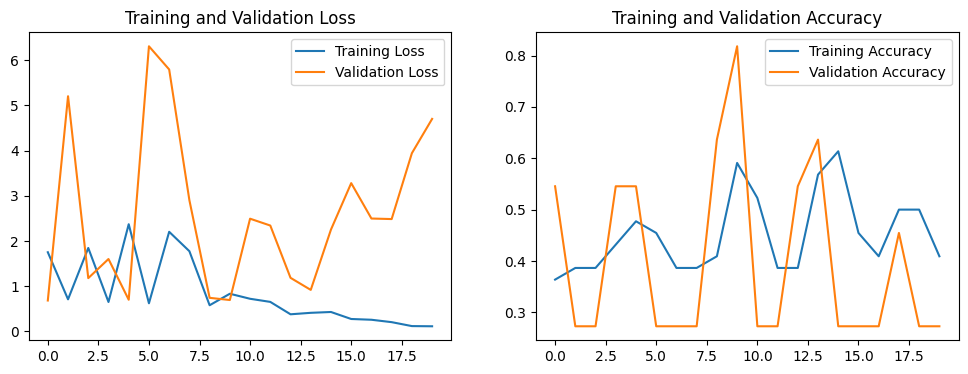

In [ ]:
 # Construcción de la red neuronal multicapa grande
model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Asumiendo clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

Epoch 1/20
2/2 [==============================] - 1s 325ms/step - loss: 0.6638 - accuracy: 0.4318 - val_loss: 6.6440 - val_accuracy: 0.2727
Epoch 2/20
2/2 [==============================] - 0s 173ms/step - loss: 1.7547 - accuracy: 0.3864 - val_loss: 1.0541 - val_accuracy: 0.5455
Epoch 3/20
2/2 [==============================] - 0s 187ms/step - loss: 1.3283 - accuracy: 0.5455 - val_loss: 2.7188 - val_accuracy: 0.2727
Epoch 4/20
2/2 [==============================] - 0s 169ms/step - loss: 0.4631 - accuracy: 0.3864 - val_loss: 1.7399 - val_accuracy: 0.3636
Epoch 5/20
2/2 [==============================] - 0s 171ms/step - loss: 0.4132 - accuracy: 0.5682 - val_loss: 1.6301 - val_accuracy: 0.4545
Epoch 6/20
2/2 [==============================] - 0s 166ms/step - loss: 0.3668 - accuracy: 0.5455 - val_loss: 3.6951 - val_accuracy: 0.2727
Epoch 7/20
2/2 [==============================] - 0s 167ms/step - loss: 0.3167 - accuracy: 0.4091 - val_loss: 2.2986 - val_accuracy: 0.2727
Epoch 8/20
2/2 [====

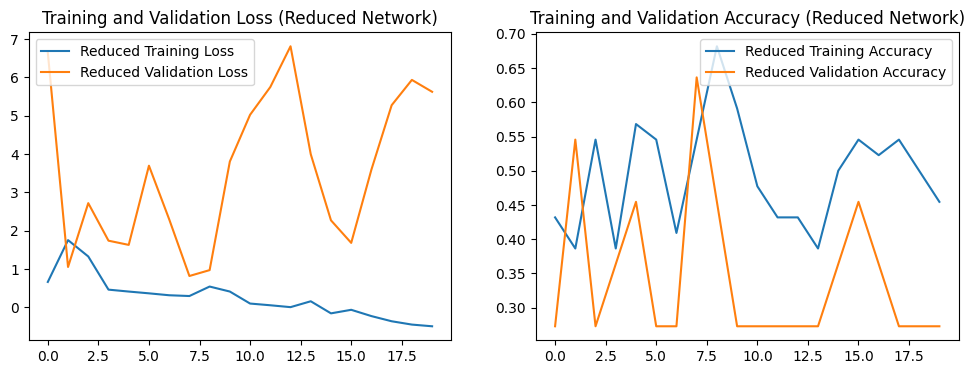

In [ ]:

 # Reducción de la red.
model_reduced = Sequential([
    Flatten(input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Asumiendo clasificación binaria
])

# Compilar el modelo reducido
model_reduced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo reducido
history_reduced = model_reduced.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Graficar la pérdida y la precisión para el modelo reducido
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_reduced.history['loss'], label='Reduced Training Loss')
plt.plot(history_reduced.history['val_loss'], label='Reduced Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Reduced Network)')

plt.subplot(1, 2, 2)
plt.plot(history_reduced.history['accuracy'], label='Reduced Training Accuracy')
plt.plot(history_reduced.history['val_accuracy'], label='Reduced Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Reduced Network)')

plt.show()

In [ ]:
predictions = model.predict(X_test)

predictions[10]

1/1 [==============================] - 0s 76ms/step


array([0.63994664], dtype=float32)

Epoch 1/20
2/2 [==============================] - 5s 2s/step - loss: 3.2898 - accuracy: 0.3864 - val_loss: 2.3455 - val_accuracy: 0.5455
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 2.3435 - accuracy: 0.4773 - val_loss: 4.1401 - val_accuracy: 0.2727
Epoch 3/20
2/2 [==============================] - 2s 823ms/step - loss: 3.7027 - accuracy: 0.3864 - val_loss: 2.9630 - val_accuracy: 0.2727
Epoch 4/20
2/2 [==============================] - 1s 660ms/step - loss: 2.9579 - accuracy: 0.3636 - val_loss: 2.5339 - val_accuracy: 0.5455
Epoch 5/20
2/2 [==============================] - 1s 705ms/step - loss: 2.7142 - accuracy: 0.4773 - val_loss: 2.6597 - val_accuracy: 0.2727
Epoch 6/20
2/2 [==============================] - 1s 661ms/step - loss: 1.8611 - accuracy: 0.4091 - val_loss: 3.4696 - val_accuracy: 0.2727
Epoch 7/20
2/2 [==============================] - 1s 674ms/step - loss: 1.8242 - accuracy: 0.4318 - val_loss: 2.2261 - val_accuracy: 0.5455
Epoch 8/20
2/2 [==========

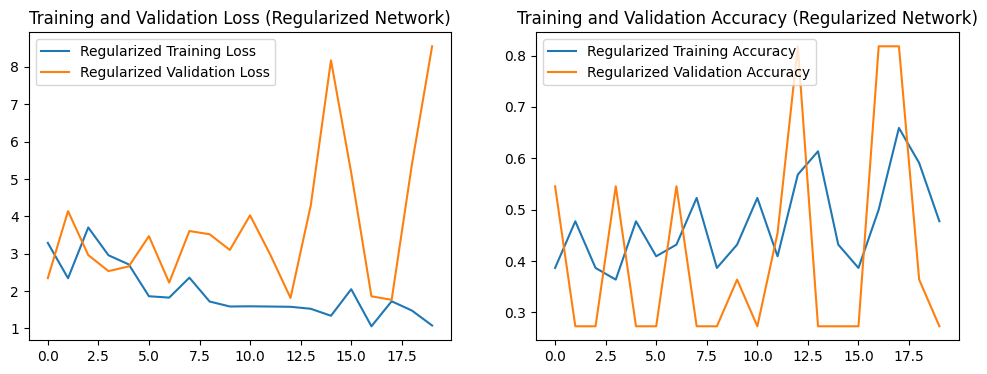

In [ ]:
from tensorflow.keras.regularizers import l2
# Regularización
model_regularized = Sequential([
    Flatten(input_shape=input_shape),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')  # Asumiendo clasificación binaria
])

# Compilar el modelo regularizado
model_regularized.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo regularizado
history_regularized = model_regularized.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Graficar la pérdida y la precisión para el modelo regularizado
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_regularized.history['loss'], label='Regularized Training Loss')
plt.plot(history_regularized.history['val_loss'], label='Regularized Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Regularized Network)')

plt.subplot(1, 2, 2)
plt.plot(history_regularized.history['accuracy'], label='Regularized Training Accuracy')
plt.plot(history_regularized.history['val_accuracy'], label='Regularized Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Regularized Network)')

plt.show()


In [63]:
predictions = model.predict(X_test)

predictions[10]

1/1 [==============================] - 0s 348ms/step


array([0.8196765], dtype=float32)

Epoch 1/20
2/2 [==============================] - 3s 798ms/step - loss: 3.3328 - accuracy: 0.2955 - val_loss: 1.4279 - val_accuracy: 0.2727
Epoch 2/20
2/2 [==============================] - 1s 589ms/step - loss: 4.8411 - accuracy: 0.5227 - val_loss: 1.0421 - val_accuracy: 0.1818
Epoch 3/20
2/2 [==============================] - 1s 616ms/step - loss: 4.7122 - accuracy: 0.4091 - val_loss: 0.8038 - val_accuracy: 0.0909
Epoch 4/20
2/2 [==============================] - 1s 783ms/step - loss: 5.9899 - accuracy: 0.3864 - val_loss: 0.6901 - val_accuracy: 0.5455
Epoch 5/20
2/2 [==============================] - 2s 882ms/step - loss: 4.5604 - accuracy: 0.5000 - val_loss: 0.8597 - val_accuracy: 0.5455
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 3.9671 - accuracy: 0.3864 - val_loss: 0.8669 - val_accuracy: 0.5455
Epoch 7/20
2/2 [==============================] - 1s 580ms/step - loss: 5.2090 - accuracy: 0.4545 - val_loss: 0.8937 - val_accuracy: 0.5455
Epoch 8/20
2/2 [=======

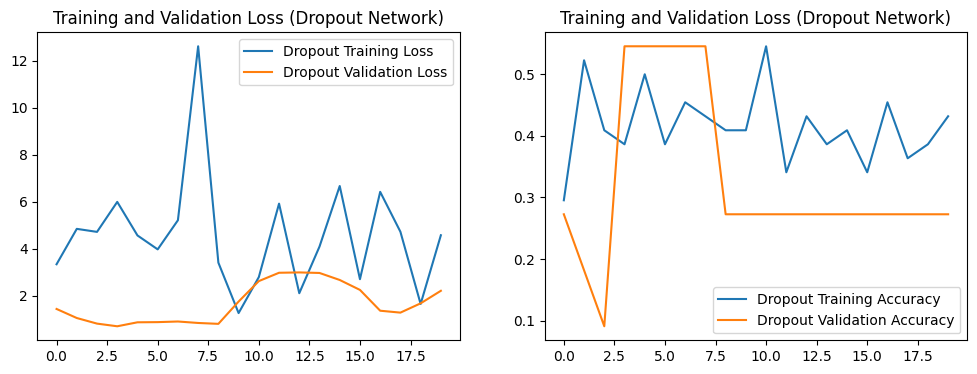

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Dropout
model_dropout = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Asumiendo clasificación binaria
])

# Compilar el modelo con dropout
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con dropout
history_dropout = model_dropout.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Graficar la pérdida y la precisión para el modelo con dropout
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['loss'], label='Dropout Training Loss')
plt.plot(history_dropout.history['val_loss'], label='Dropout Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Dropout Network)')

plt.subplot(1, 2, 2)
plt.plot(history_dropout.history['accuracy'], label='Dropout Training Accuracy')
plt.plot(history_dropout.history['val_accuracy'], label='Dropout Validation Accuracy')
plt.legend()
plt.title('Training and Validation Loss (Dropout Network)')



plt.show()

In [62]:
predictions = model.predict(X_test)

predictions[10]

1/1 [==============================] - 0s 343ms/step


array([0.8196765], dtype=float32)

In [54]:

import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Epoch 1/20
2/2 [==============================] - 17s 6s/step - loss: 0.6930 - accuracy: 0.4773 - val_loss: 0.8442 - val_accuracy: 0.2727
Epoch 2/20
2/2 [==============================] - 14s 2s/step - loss: 0.7241 - accuracy: 0.4091 - val_loss: 0.8243 - val_accuracy: 0.2727
Epoch 3/20
2/2 [==============================] - 7s 3s/step - loss: 0.8180 - accuracy: 0.3409 - val_loss: 0.7027 - val_accuracy: 0.2727
Epoch 4/20
2/2 [==============================] - 6s 2s/step - loss: 0.7371 - accuracy: 0.3864 - val_loss: 0.5890 - val_accuracy: 0.2727
Epoch 5/20
2/2 [==============================] - 10s 3s/step - loss: 0.6009 - accuracy: 0.3636 - val_loss: 0.5729 - val_accuracy: 0.3636
Epoch 6/20
2/2 [==============================] - 6s 2s/step - loss: 0.5234 - accuracy: 0.3864 - val_loss: 0.5251 - val_accuracy: 0.3636
Epoch 7/20
2/2 [==============================] - 9s 2s/step - loss: 0.5668 - accuracy: 0.3864 - val_loss: 0.4981 - val_accuracy: 0.3636
Epoch 8/20
2/2 [======================

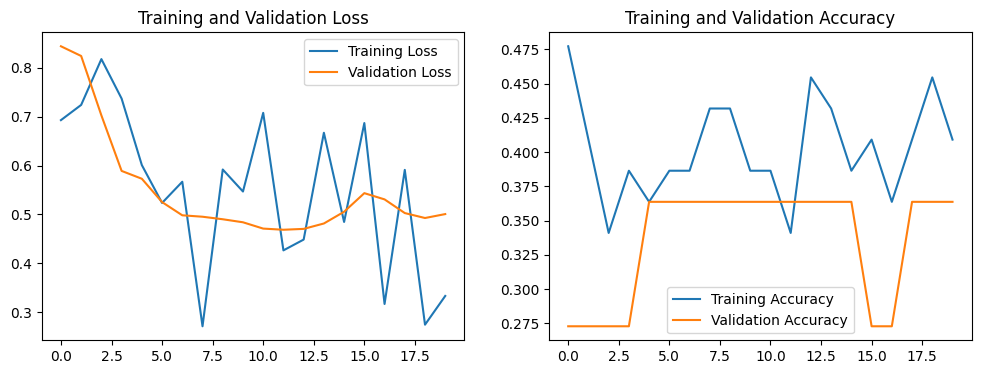

In [55]:
#Ahora realizo CNN.


model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Asumiendo clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [56]:
predictions = model.predict(X_test)

predictions[10]

1/1 [==============================] - 0s 428ms/step


array([0.8196765], dtype=float32)

In [ ]:
#Conclusion:

#Mediante CNN, se mejoro la prediccion del modelo, pero aun falta mejorarlo al agregar mas imagenes , ya que solo analizamos 55 imagenes.